In [1]:
import os, glob
import librosa, soundfile
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [2]:
def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate

        if chroma:
            stft = np.abs(librosa.stft(X))
        
        result = np.array([])
        # find mean over entire time length for each frequency in the frequency range
        # and then horizontally stack it to the `result` array
        # result array contains [ mfccs, chroma, mel ] in that order
        # result array has only one axis,
        # representing the features vector extracted from the sound_file
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
        
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
            result = np.hstack((result, chroma))
        
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
            result = np.hstack((result, mel))
    return result        

In [16]:
emotions = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

In [17]:
def load_data(test_size=0.2):
    x,y = [], []
    for file in glob.glob("./speech-emotion-recognition-ravdess-data/Actor_*/*.wav"):
        file_name = os.path.basename(file)
        emotion = emotions[file_name.split("-")[2]]

        # if emotion not in list(emotions.values()):
        #     continue
        feature = extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)
    
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [18]:
X_train, X_test, y_train, y_test = load_data(test_size=0.25)
print(X_train.shape, X_test.shape)

(1080, 180) (360, 180)


In [19]:
print(f"Features extracted: {X_train.shape[1]}")

Features extracted: 180


In [94]:
#Use Multi-Layer Perceptron Classifier
model = MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(1080,500, 300,), learning_rate='adaptive', max_iter=1000, verbose=True, activation="logistic")

In [95]:
model.fit(X_train, y_train)

Iteration 1, loss = 2.11178972
Iteration 2, loss = 2.09318799
Iteration 3, loss = 2.05049928
Iteration 4, loss = 1.99592904
Iteration 5, loss = 1.93902451
Iteration 6, loss = 1.88653514
Iteration 7, loss = 1.84468695
Iteration 8, loss = 1.80720010
Iteration 9, loss = 1.78799711
Iteration 10, loss = 1.75529921
Iteration 11, loss = 1.75501453
Iteration 12, loss = 1.73129882
Iteration 13, loss = 1.71835524
Iteration 14, loss = 1.69492123
Iteration 15, loss = 1.68421512
Iteration 16, loss = 1.68398745
Iteration 17, loss = 1.64542650
Iteration 18, loss = 1.62338227
Iteration 19, loss = 1.59741115
Iteration 20, loss = 1.57510903
Iteration 21, loss = 1.58186244
Iteration 22, loss = 1.52968605
Iteration 23, loss = 1.50938518
Iteration 24, loss = 1.49299261
Iteration 25, loss = 1.46236734
Iteration 26, loss = 1.46727431
Iteration 27, loss = 1.48157544
Iteration 28, loss = 1.46111062
Iteration 29, loss = 1.50061793
Iteration 30, loss = 1.46276402
Iteration 31, loss = 1.42516835
Iteration 32, los

MLPClassifier(activation='logistic', alpha=0.01, batch_size=256,
              hidden_layer_sizes=(1080, 500, 300), learning_rate='adaptive',
              max_iter=1000, verbose=True)

In [96]:
y_pred = model.predict(X_test)

In [97]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 60.28%


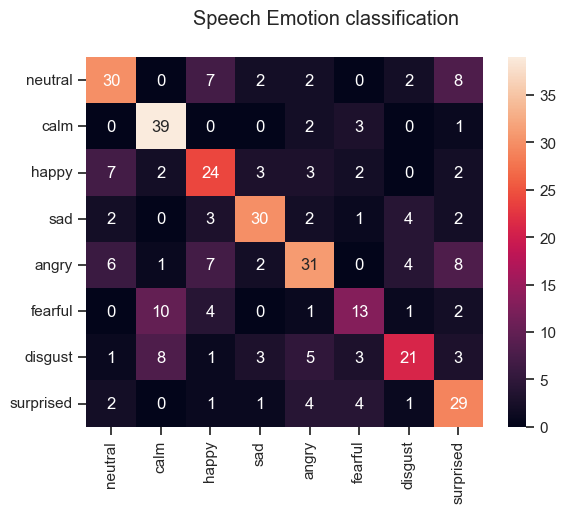

In [110]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
from sklearn.metrics import confusion_matrix
seaborn.set(style='ticks')

plt.figure(1)
plt.suptitle("Speech Emotion classification")
seaborn.heatmap(confusion_matrix(y_test,y_pred), xticklabels=list(emotions.values()), yticklabels=list(emotions.values()), annot=True, fmt="1d")
plt.show()

----
#### Exploring `librosa`

In [111]:
from IPython.display import Audio

<class 'numpy.ndarray'> <class 'int'>
(92703,) 22050
[-0.00312528 -0.00307316 -0.00297001 -0.00289993 -0.00288754 -0.00284543
 -0.00276689 -0.00266533 -0.00252735 -0.00240009]


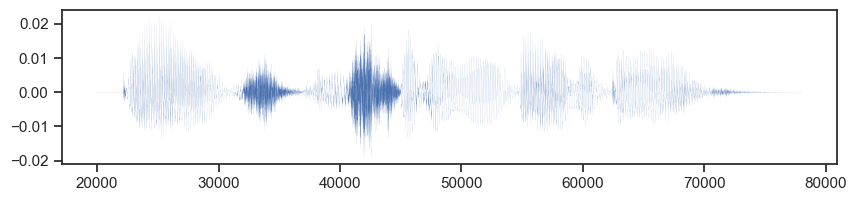

(1025, 182)


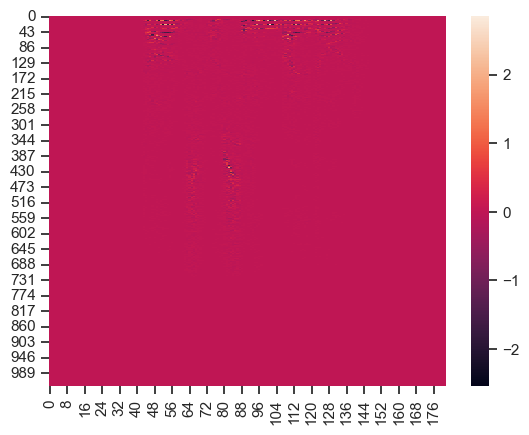

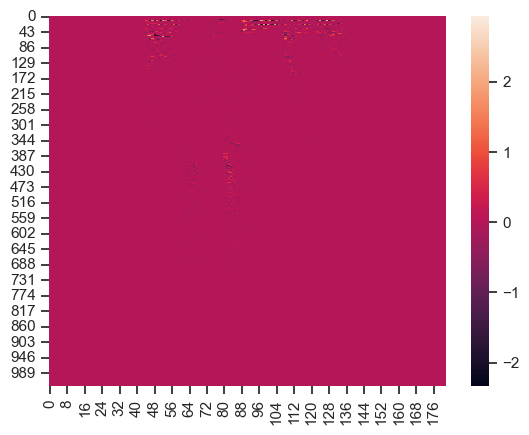

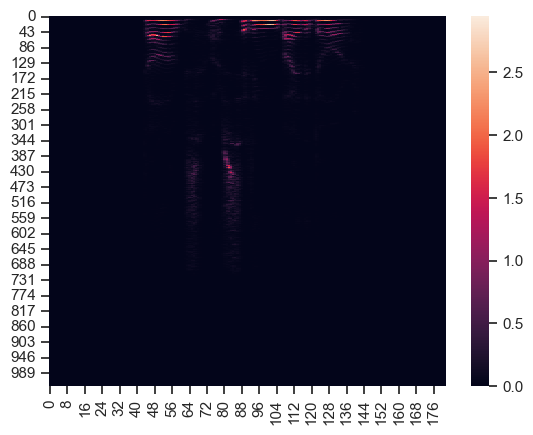

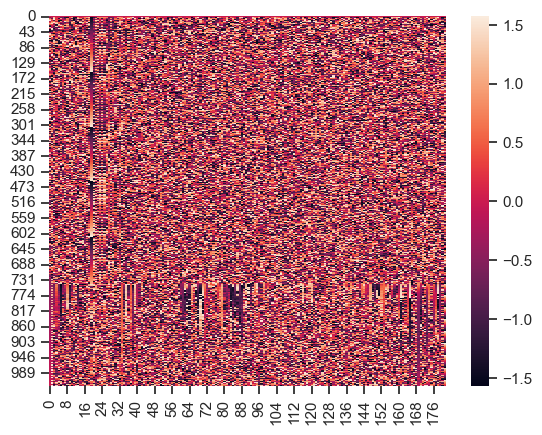

In [112]:
testfile_path = glob.glob("./speech-emotion-recognition-ravdess-data/Actor_*/*.wav")[10]

y, sr = librosa.load(testfile_path)

print(type(y), type(sr))
print(y.shape, sr)
print(y[30000:30010])
t = np.arange(len(y))
plt.figure(figsize=(10,2))
plt.plot(t[20000:78000],y[20000:78000], linewidth=0.04)
plt.show()
D = librosa.stft(y)
print(D.shape)
plt.figure(2)
seaborn.heatmap(D.imag)
plt.show()
plt.figure(3)
seaborn.heatmap(D.real)
plt.show()
plt.figure(4)
seaborn.heatmap(np.sqrt(D.real**2 + D.imag**2))
plt.show()
plt.figure(5)
seaborn.heatmap(np.arctan(D.imag/D.real))
plt.show()
Audio(data=y, rate=sr)

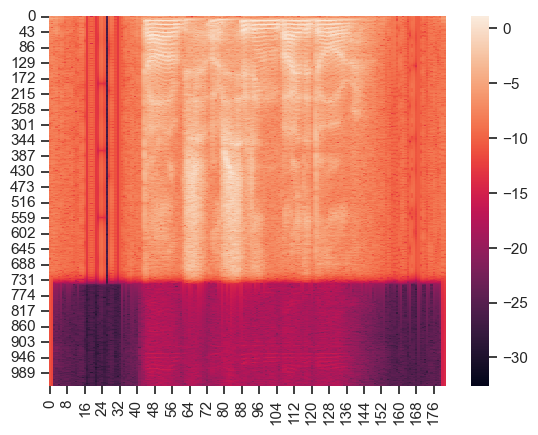

In [113]:
plt.figure(6)
seaborn.heatmap(np.log(np.sqrt(D.real**2 + D.imag**2)))
plt.show()

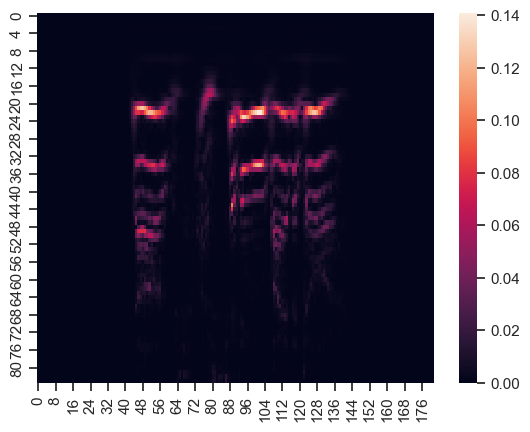

In [114]:
C = librosa.cqt(y,sr=sr)
plt.figure(7)
seaborn.heatmap((np.sqrt(C.real**2 + C.imag**2)))
plt.show()

C:\Users\adity\AppData\Local\Temp\ipykernel_15788\433254453.py:4: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  librosa.display.specshow(chroma, x_axis="time", y_axis="chroma")


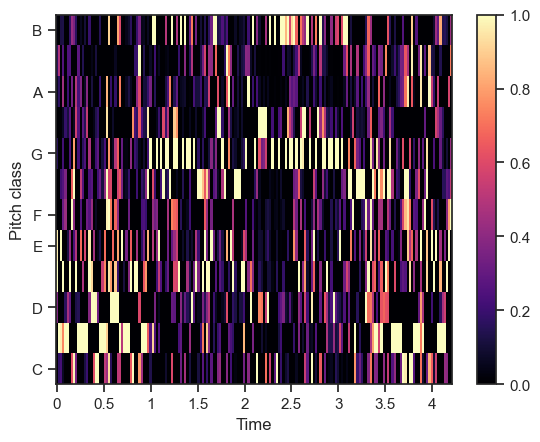

(20, 182)
[[-895.43756  -874.78033  -879.1321  ]
 [  46.861603   47.337547   45.183773]
 [  19.428524   13.269804   13.441006]]


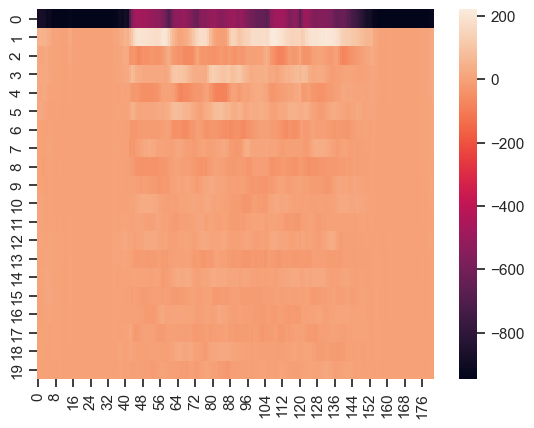

(128, 182)
[[1.6132966e-06 1.2276014e-06 2.7554498e-07]
 [5.7177454e-06 8.8859842e-06 3.9796969e-06]
 [3.2314697e-06 4.9190335e-06 1.4432549e-06]]


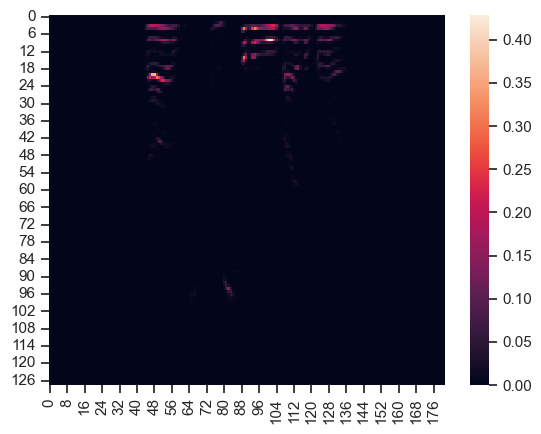

In [115]:
chroma = librosa.feature.chroma_cqt(C=C, sr=sr)
plt.figure(8)
# seaborn.heatmap(chroma)
librosa.display.specshow(chroma, x_axis="time", y_axis="chroma")
plt.colorbar()
plt.show()
MFCC = librosa.feature.mfcc(y=y, sr=sr)
print(MFCC.shape)
print(MFCC[:3,:3])
plt.figure(9)
seaborn.heatmap(MFCC)
plt.show()
melspec = librosa.feature.melspectrogram(y=y, sr=sr)
print(melspec.shape)
print(melspec[:3,:3])
plt.figure(9)
seaborn.heatmap(melspec)
plt.show()

In [117]:
testfile_path = glob.glob("./speech-emotion-recognition-ravdess-data/Actor_*/*.wav")[10]

with soundfile.SoundFile(testfile_path) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate

        if True:
            stft = librosa.stft(X)
            print("stft shape:" ,stft.shape)
        
        result = np.array([[] for i in np.arange(stft.shape[1])])
        # find mean over entire time for each frequency
        # in the frequency range
        if True:
            mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T
            print("mfccs shape:" ,mfccs.shape)
            result = np.hstack((result, mfccs))
        
        if True:
            chroma = librosa.feature.chroma_stft(S=stft, sr=sample_rate).T
            print("chroma shape:" ,chroma.shape)
            result = np.hstack((result, chroma))
        
        if True:
            mel = librosa.feature.melspectrogram(y=X, sr=sample_rate).T
            print("mel shape:" ,mel.shape)
            result = np.hstack((result, mel))
        
        print("result shape:", result.shape)


stft shape: (1025, 132)
mfccs shape: (132, 40)
chroma shape: (132, 12)
mel shape: (132, 128)
result shape: (132, 180)


----

In [118]:
mfccs.shape

(132, 40)

In [119]:
chroma.shape

(132, 12)

In [120]:
mel.shape

(132, 128)

In [121]:
result.shape

(132, 180)